In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Using device: mps


In [2]:
def theta_exact_np(x,t):
    return ((np.pi / 2.0)*np.cos(x) + (x - np.pi/2.0)) * np.cos(t)

def w_exact_np(x, t):
    return (np.pi / 2.0) * np.sin(x) * np.cos(t)

def g_np(x,t):
    return np.cos(t) - (np.pi/2.0) * np.sin(x) * np.cos(t)

def add_relative_noise(arr, rel_std):
    eps = 1e-12
    scale = np.maximum(np.abs(arr), eps)
    noise = np.random.normal(0.0, rel_std, size=arr.shape)
    return arr + noise * scale

def to_torch(a):
    return torch.from_numpy(a).to(torch.float32)

def grad(y,x):
    return torch.autograd.grad(y,x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]

def split_theta_w(u):
    return u[:, :1], u[:, 1:2]

def to_device_batch(dct, device):
    out = {}
    for k, v in dct.items():
        out[k] = v.to(device) if torch.is_tensor(v) else v
    return out

In [3]:
def make_inverse_single_beam_data(
        Ni = 200, Nb=400, Nint = 1000, Ndata=5000,
        x_obs = (0.2, 0.8, 1.8, 2.6, 3.0),
        theta_rel_noise = 1e-6,
        w_rel_noise = 1e-5,
):
        # Collocation Points
        x_int = np.random.uniform(0.0, np.pi, size=(Nint, 1))
        t_int = np.random.uniform(0.0, 1.0, size=(Nint,1))
        g_int = g_np(x_int, t_int)

        # Initial Condition
        x_i = np.random.uniform(0.0, np.pi, size=(Ni,1))
        t_i = np.zeros((Ni,1))
        theta_i = theta_exact_np(x_i,t_i)
        w_i = w_exact_np(x_i, t_i)
        theta_t_i = np.zeros_like(theta_i)
        w_t_i = np.zeros_like(w_i)

        # Boundary Condition
        t_b = np.random.uniform(0.0,1.0,size=(Nb,1))
        half = Nb // 2
        x_b_left, t_b_left = np.zeros((half,1)), t_b[:half]
        x_b_right, t_b_right = np.full((Nb-half, 1), np.pi), t_b[half:]
        theta_b_left = np.zeros_like(x_b_left)
        w_b_left     = np.zeros_like(x_b_left)
        theta_b_right = np.zeros_like(x_b_right)
        w_b_right     = np.zeros_like(x_b_right)

        # Observed data
        per = Ndata // len(x_obs)   # How many data points per sensor
        rem = Ndata - per * len(x_obs)
        xs, ts = [], []     # Store x and t values at observation points
        for i, xl in enumerate(x_obs):
                n = per + (1 if i < rem else 0)
                xs.append(np.full((n,1), xl))   # Fix x value with differing time
                ts.append(np.random.uniform(0.0,1.0, size = (n,1)))

        x_data = np.vstack(xs)  # Shape : (Ndata, 1)
        t_data = np.vstack(ts)  # Shape : (Ndata, 1)

        # Clean observation (no noise)
        theta_data = theta_exact_np(x_data, t_data)
        w_data     = w_exact_np(x_data, t_data)

        # Noisy observation
        theta_data_noisy = add_relative_noise(theta_data, theta_rel_noise)
        w_data_noisy     = add_relative_noise(w_data,     w_rel_noise)

        # Compute scaling bounds for normalization
        X_true = np.hstack((
                np.vstack([x_int, x_i, x_b_left, x_b_right, x_data]),
                np.vstack([t_int, t_i, t_b_left, t_b_right, t_data])
        ))
        lb = X_true.min(axis=0)
        ub = X_true.max(axis=0)

        data = {
        "x_int": to_torch(x_int), "t_int": to_torch(t_int), "g_int": to_torch(g_int),
        "x_i": to_torch(x_i), "t_i": to_torch(t_i),
        "theta_i": to_torch(theta_i), "w_i": to_torch(w_i),
        "theta_t_i": to_torch(theta_t_i), "w_t_i": to_torch(w_t_i),
        "x_b_left": to_torch(x_b_left), "t_b_left": to_torch(t_b_left),
        "theta_b_left": to_torch(theta_b_left), "w_b_left": to_torch(w_b_left),
        "x_b_right": to_torch(x_b_right), "t_b_right": to_torch(t_b_right),
        "theta_b_right": to_torch(theta_b_right), "w_b_right": to_torch(w_b_right),
        "x_data": to_torch(x_data), "t_data": to_torch(t_data),

        # noisy
        "theta_obs": to_torch(theta_data_noisy), "w_obs": to_torch(w_data_noisy),

        # clean
        "theta_obs_clean": to_torch(theta_data), "w_obs_clean": to_torch(w_data),

        "lb": to_torch(lb),
        "ub": to_torch(ub),
        }

        return data

In [4]:
data = make_inverse_single_beam_data()

lower_bound = data["lb"]
upper_bound = data["ub"]

In [5]:
class PINN(nn.Module):
    def __init__(self, lower_bound, upper_bound, input_size = 2, hidden_size=20, output_size = 2, num_layers=4):
        super().__init__()

        # upper & lower bound for normalization
        lb = lower_bound.view(1,-1).to(torch.float32)
        ub = upper_bound.view(1,-1).to(torch.float32)
        self.register_buffer("lb", lb)
        self.register_buffer("ub", ub)

        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())
        for _ in range(num_layers-1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

        for m in self.network:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # feature scaling
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        x = x.to(self.lb.device, dtype=torch.float32)
        x = (x - self.lb) / (self.ub - self.lb)
        # Forward
        y = self.network(x)
        return y    # y[:, :1]=theta, y[:, 1:2]=w

In [6]:
def loss_pde(model, alpha, x_int, t_int, g_int):
    x = x_int.detach().requires_grad_(True)
    t = t_int.detach().requires_grad_(True)
    X = torch.cat([x,t], dim=1)

    u = model(X)
    theta, w = split_theta_w(u)

    theta_t  = grad(theta,t)
    theta_tt = grad(theta_t, t)
    w_t      = grad(w,t)
    w_tt     = grad(w_t, t)

    theta_x  = grad(theta, x)
    theta_xx = grad(theta_x, x)
    w_x      = grad(w,x)
    w_xx     = grad(w_x, x)

    eq1 = alpha * theta_tt - theta_xx + (theta - w_x)
    eq2 = w_tt + (theta_x - w_xx) - g_int

    loss_pde = (eq1**2).mean() + (eq2**2).mean()
    return loss_pde

def loss_ic(model, x_i, t_i, theta_i, w_i, theta_t_i, w_t_i):
    x = x_i.detach()
    t = t_i.detach().requires_grad_(True)
    X = torch.cat([x,t], dim=1)

    u = model(X)
    theta, w = split_theta_w(u)

    theta_t = grad(theta, t)
    w_t     = grad(w,t)

    loss_ic = ((theta-theta_i)**2).mean() + ((w-w_i)**2).mean() + \
              ((theta_t - theta_t_i)**2).mean() + ((w_t - w_t_i)**2).mean()
    return loss_ic

def loss_bc(model, x_bl, t_bl, theta_bl, w_bl, x_br, t_br, theta_br, w_br):
    xl = x_bl.detach().requires_grad_(True)
    tl = t_bl.detach().requires_grad_(True)
    Xl = torch.cat([xl, tl], dim=1)
    ul = model(Xl)
    th_l, w_l = split_theta_w(ul)

    xr = x_br.detach().requires_grad_(True)
    tr = t_br.detach().requires_grad_(True)
    Xr = torch.cat([xr, tr], dim=1)
    ur = model(Xr)
    th_r, w_r = split_theta_w(ur)

    loss_bc = ((th_l - theta_bl)**2).mean() + ((w_l - w_bl)**2).mean() + \
              ((th_r - theta_br)**2).mean() + ((w_r - w_br)**2).mean()
    return loss_bc

def loss_data(model, x_d, t_d, theta_obs, w_obs):
    Xd = torch.cat([x_d.detach(), t_d.detach()], dim=1)
    u = model(Xd)
    theta, w = split_theta_w(u)
    loss_data = ((theta - theta_obs)**2).mean() + ((w - w_obs)**2).mean()
    return loss_data

def total_loss(model, alpha, data, weights = (1.0, 1.0, 1.0, 1.0)):
    w_pde, w_ic, w_bc, w_data = weights
    lpde = loss_pde(model, alpha, data["x_int"], data["t_int"], data["g_int"])
    lic  = loss_ic(model, data["x_i"], data["t_i"], data["theta_i"], data["w_i"],
                   data["theta_t_i"], data["w_t_i"])
    lbc  = loss_bc(model,
                   data["x_b_left"], data["t_b_left"], data["theta_b_left"], data["w_b_left"],
                   data["x_b_right"], data["t_b_right"], data["theta_b_right"], data["w_b_right"])
    ldat = loss_data(model, data["x_data"], data["t_data"], data["theta_obs"], data["w_obs"])
    L = w_pde*lpde + w_ic*lic + w_bc*lbc + w_data*ldat
    terms = {"pde": lpde.detach(), "ic": lic.detach(), "bc": lbc.detach(), "data": ldat.detach()}
    return L, terms

In [7]:
def train_pinn(model, alpha, data, epochs = 5000, lr = 1e-3, weights = (1.0, 1.0, 1.0, 1.0)):
    optimizer = optim.LBFGS(
        list(model.parameters()) + [alpha],
        lr=1.0,
        max_iter=1,
        history_size=100,
        line_search_fn="strong_wolfe"
    )

    losses = []
    pbar = tqdm(range(epochs), desc="Training PINN (L-BFGS)")

    for ep in pbar:
        def closure():
            optimizer.zero_grad()
            L, terms = total_loss(model, alpha, data, weights)
            L.backward()
            closure.loss, closure.terms = L, terms
            return L

        optimizer.step(closure)
        L, terms = closure.loss, closure.terms
        losses.append(L.item())

        if ep % 100 == 0:
            pbar.set_postfix({
                "Loss": f"{L.item():.3e}",
                "PDE": f"{terms['pde'].item():.2e}",
                "IC": f"{terms['ic'].item():.2e}",
                "BC": f"{terms['bc'].item():.2e}",
                "DATA": f"{terms['data'].item():.2e}",
                "alpha": f"{alpha.item():.6f}",
            })

    pbar.close()
    return model, alpha, losses

In [8]:
# 1) noisy dataset
data_noisy = to_device_batch(data.copy(), device)

# 2) clean dataset
data_clean = data.copy()
data_clean["theta_obs"] = data_clean["theta_obs_clean"]
data_clean["w_obs"]     = data_clean["w_obs_clean"]
data_clean = to_device_batch(data_clean, device)

# bounds
lower_bound = data["lb"]
upper_bound = data["ub"]

# Noisy data training
torch.manual_seed(42); np.random.seed(42)
model = PINN(lower_bound, upper_bound, input_size=2, hidden_size=20, output_size=2, num_layers=4).to(device)
alpha = nn.Parameter(torch.tensor([1.0], dtype=torch.float32, device=device), requires_grad=True)
epochs = 5000
model_trained_noisy, alpha_learned_noisy, losses_noisy = train_pinn(
    model, alpha, data_noisy,
    epochs=epochs, lr=1.0, weights=(1.0, 1.0, 1.0, 1.0)
)

# Clean data training
torch.manual_seed(42); np.random.seed(42)
model = PINN(lower_bound, upper_bound, input_size=2, hidden_size=20, output_size=2, num_layers=4).to(device)
alpha = nn.Parameter(torch.tensor([1.0], dtype=torch.float32, device=device), requires_grad=True)
model_trained_clean, alpha_learned_clean, losses_clean = train_pinn(
    model, alpha, data_clean,
    epochs=epochs, lr=1.0, weights=(1.0, 1.0, 1.0, 1.0)
)

Training PINN (L-BFGS): 100%|██████████| 5000/5000 [08:48<00:00,  9.46it/s, Loss=6.387e-06, PDE=2.26e-06, IC=2.00e-06, BC=1.60e-06, DATA=5.15e-07, alpha=0.997621]



[NOISY ] alpha = 0.995850 (rel. err 0.415%)
[CLEAN ] alpha = 0.997621 (rel. err 0.238%)


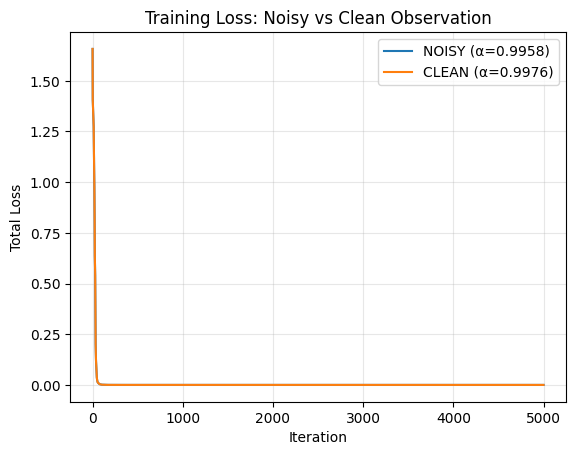

In [9]:
true_alpha = 1.0
a_n = alpha_learned_noisy.item()
a_c = alpha_learned_clean.item()
err_n = abs(a_n - true_alpha)/true_alpha*100
err_c = abs(a_c - true_alpha)/true_alpha*100

print(f"\n[NOISY ] alpha = {a_n:.6f} (rel. err {err_n:.3f}%)")
print(f"[CLEAN ] alpha = {a_c:.6f} (rel. err {err_c:.3f}%)")

# Lost curve comparison
plt.figure()
plt.plot(losses_noisy, label=f"NOISY (α={a_n:.4f})")
plt.plot(losses_clean, label=f"CLEAN (α={a_c:.4f})")
plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.title("Training Loss: Noisy vs Clean Observation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()